In [11]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import jax.numpy as jnp
import jax.nn as jnn
import numpy as np

from src.pde import fd_solve, u_exact
from src.pinn import train_pinn, evaluate_pinn
from src.experiment import test_explicit_scheme, run_architecture_sweep
from src.plotting import (
    plot_all_heatmaps,
    plot_scheme_errors_t1,
    plot_scheme_errors_t2,
    plot_3d_surface,
    subplot_3d_surface,
)


# Part B
Plots for $\Delta x = 1/10$ and $\Delta t = 1/100$

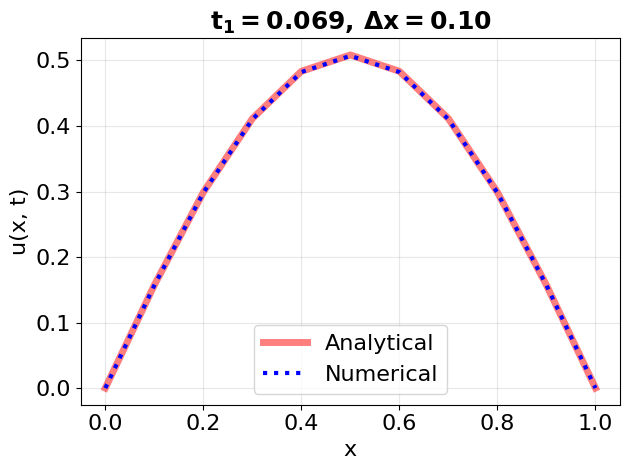

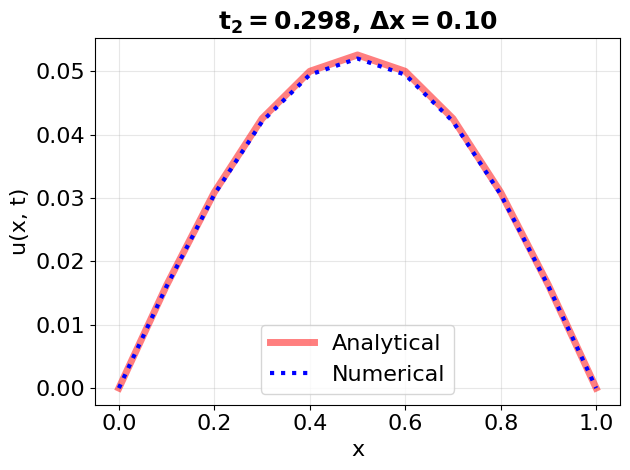

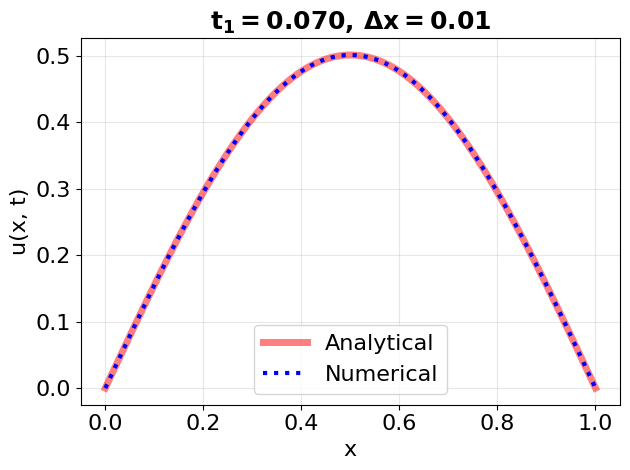

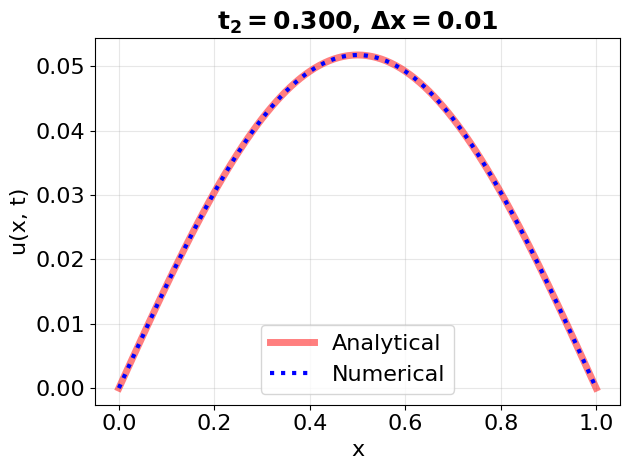

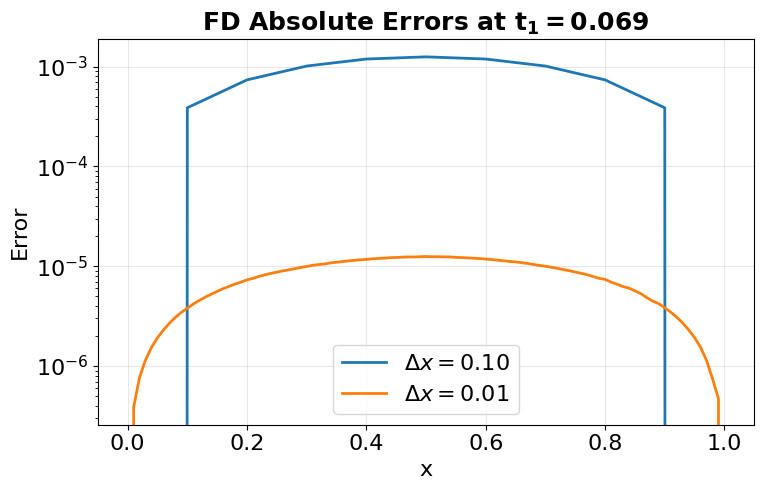

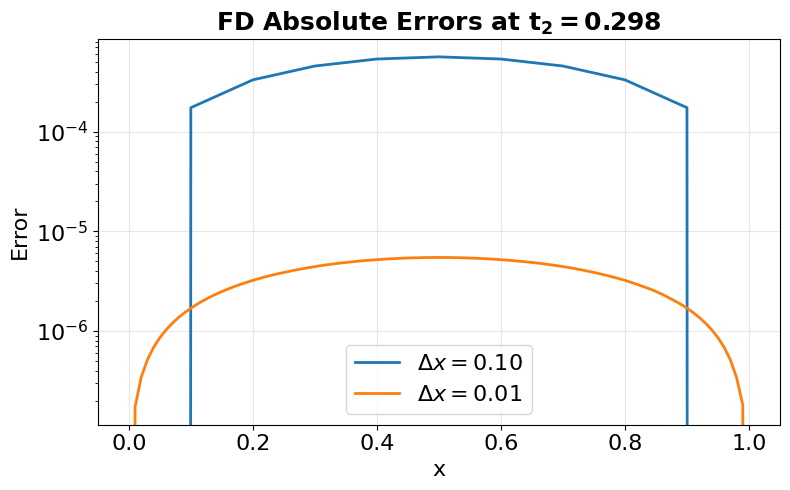

In [12]:
errors = []
errors.append(test_explicit_scheme(Nx=10))
errors.append(test_explicit_scheme(Nx=100))

plot_scheme_errors_t1(errors, title=rf"FD Absolute Errors at $\mathbf{{t_1 = {errors[0]['t1']:.3f}}}$", filepath="../figs/errors_t1.pdf")
plot_scheme_errors_t2(errors, title=rf"FD Absolute Errors at $\mathbf{{t_2 = {errors[0]['t2']:.3f}}}$", filepath="../figs/errors_t2.pdf")

# Part C
Solving same problem as for part b, but now using PINNS

[step    0] loss = 2.182e+01
[step  500] loss = 1.397e+00
[step 1000] loss = 1.718e-01
[step 1500] loss = 2.450e-02
[step 2000] loss = 8.779e-03
[step 2500] loss = 4.711e-03
[step 3000] loss = 2.629e-03
[step 3500] loss = 1.471e-03
[step 4000] loss = 8.104e-04
[step 4500] loss = 4.996e-04
[step 5000] loss = 3.553e-04
[step 5500] loss = 2.774e-04
[step 6000] loss = 2.121e-04
[step 6500] loss = 1.668e-04
[step 7000] loss = 1.350e-04
[step 7500] loss = 1.016e-04
[step 8000] loss = 8.548e-05
[step 8500] loss = 6.261e-05
[step 9000] loss = 5.229e-05
[step 9500] loss = 3.463e-05
[step 9999] loss = 2.766e-05


/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:112: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.savefig(save_path, dpi=300, bbox_inches="tight", pad_inches=0.1)
/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels([""] * len(ax.get_zticks()))
/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels([""] * len(ax.get_zticks()))
/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarn

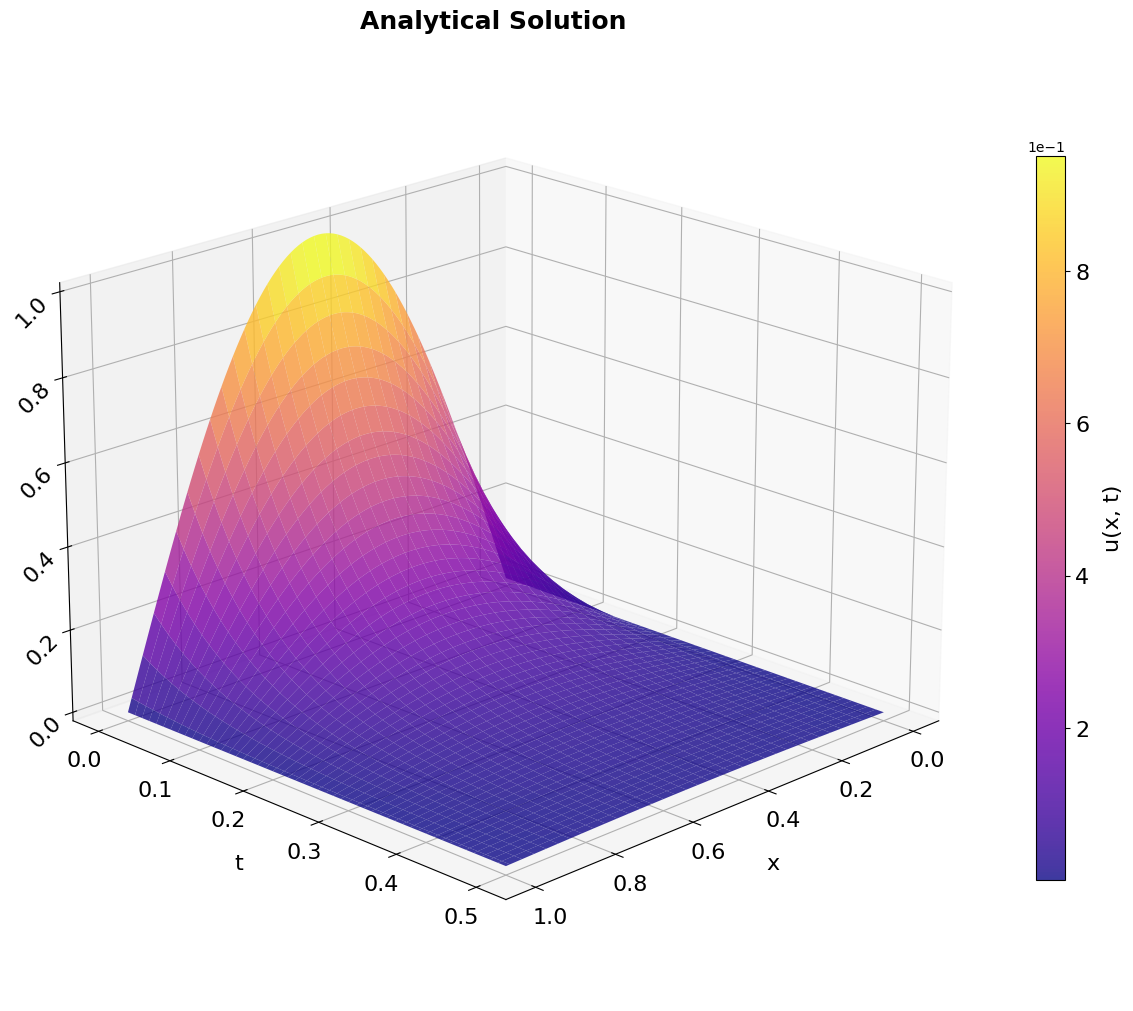

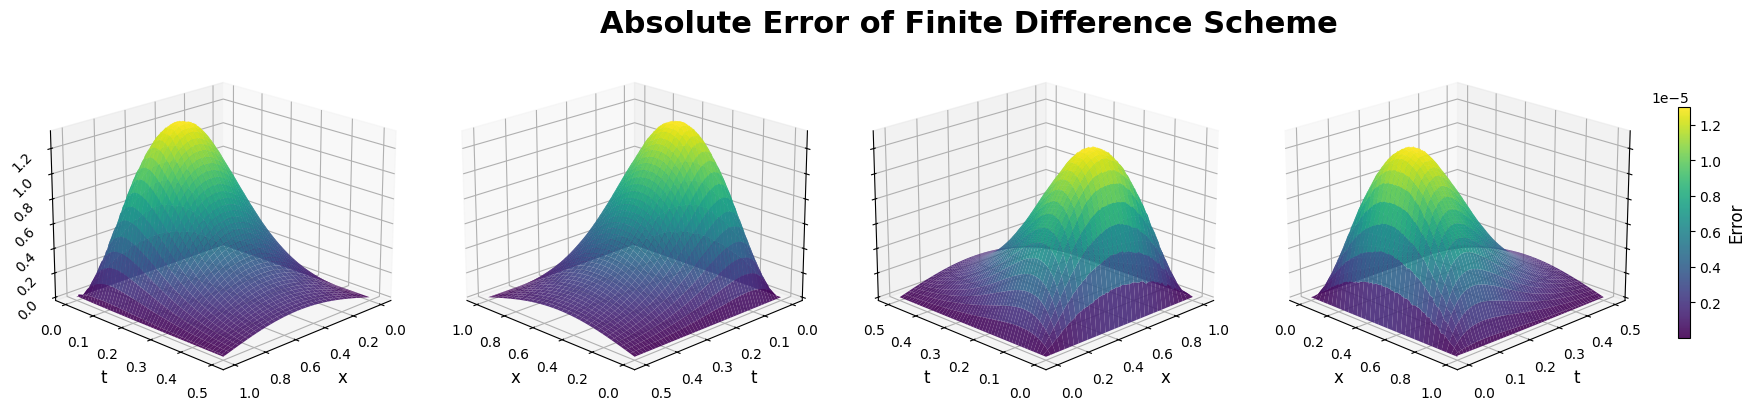

/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels([""] * len(ax.get_zticks()))
/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels([""] * len(ax.get_zticks()))
/Users/adamfalchenberg/dev/adam/school/FYS-STK4155/projects/FYS-STK4155/project3/code/src/plotting.py:172: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_zticklabels([""] * len(ax.get_zticks()))


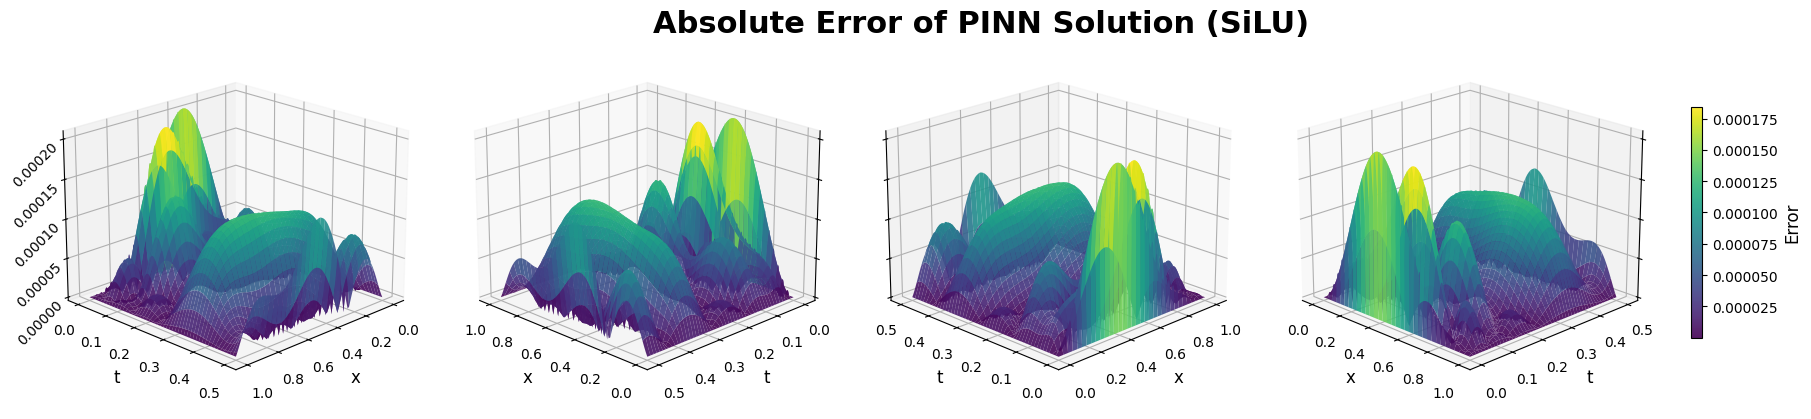

In [13]:
# Finite Difference scheme
u_fd, x, t = fd_solve(Nx=100, T=0.5, alpha=0.4)
u_true = u_exact(x, t)

# SiLU Activation
model_silu, losses_silu = train_pinn(
    steps=10000,
    layers=[2, 32, 32, 32, 1],
    activations=[jnn.silu, jnn.silu, jnn.silu],
    N_int=10000,
)

u_nn_silu = evaluate_pinn(model_silu, x, t)

# Error surfaces
error_fd = np.abs(u_fd - u_true)
u_true_pinn = u_exact(x, t)
error_nn_silu = np.abs(u_nn_silu - u_true_pinn)

# Plotting
rotations = [45, 135, 225, 315]

fd_surfaces = [error_fd for _ in rotations]
pinn_surfaces_silu = [error_nn_silu for _ in rotations]

# Surface plots of solutions
plot_3d_surface(
    x,
    t,
    u_true,
    elev=20,
    azim=45,
    save_path="../figs/exact_solution.pdf",
    title="Analytical Solution",
)

subplot_3d_surface(
    x,
    t,
    fd_surfaces,
    elev=20,
    azims=rotations,
    save_path="../figs/fd_error_surfaces.pdf",
    title="Absolute Error of Finite Difference Scheme",
)

subplot_3d_surface(
    x,
    t,
    pinn_surfaces_silu,
    elev=20,
    azims=rotations,
    save_path="../figs/pinn_error_surfaces_silu.pdf",
    title="Absolute Error of PINN Solution (SiLU)",
)


# Part d)

Loading pre-computed results from CSV files...
Loaded ../data/sweep_tanh.csv
Loaded ../data/sweep_sine.csv
Loaded ../data/sweep_GeLU.csv
Loaded ../data/sweep_SiLU.csv
Loaded ../data/sweep_ReLU.csv

Loaded 450 individual results
Aggregated to 45 configurations
Creating heatmap for activation: GeLU


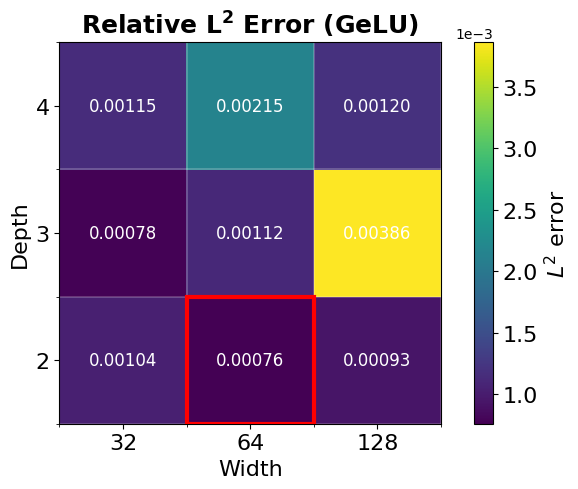

Saved: ../figs/heatmap_activation_GeLU.pdf
Creating heatmap for activation: ReLU


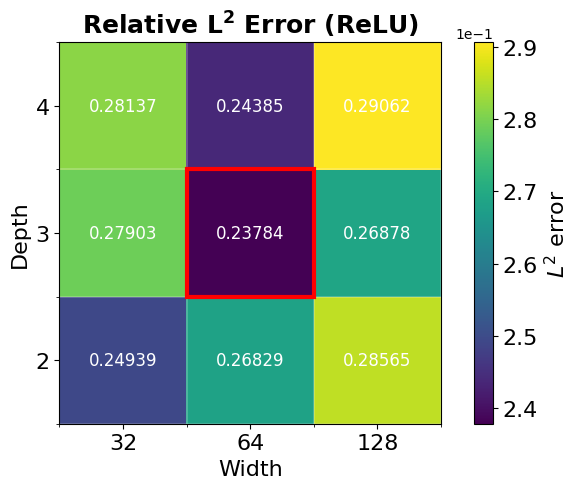

Saved: ../figs/heatmap_activation_ReLU.pdf
Creating heatmap for activation: SiLU


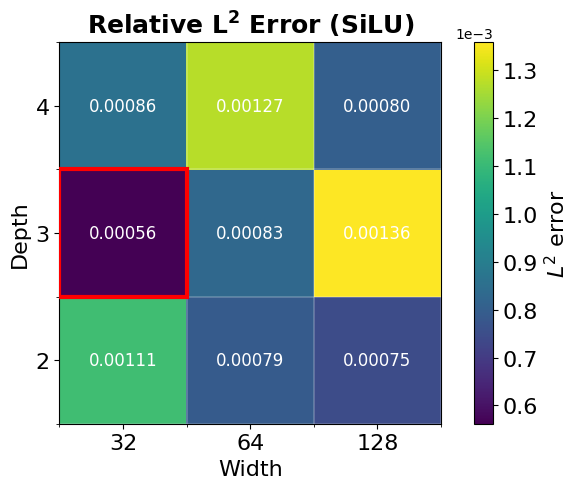

Saved: ../figs/heatmap_activation_SiLU.pdf
Creating heatmap for activation: sine


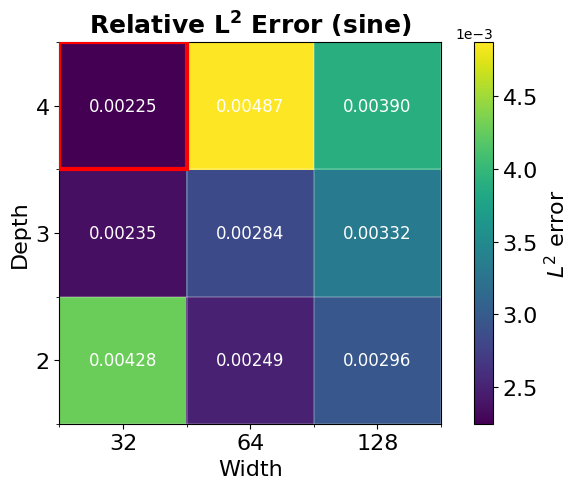

Saved: ../figs/heatmap_activation_sine.pdf
Creating heatmap for activation: tanh


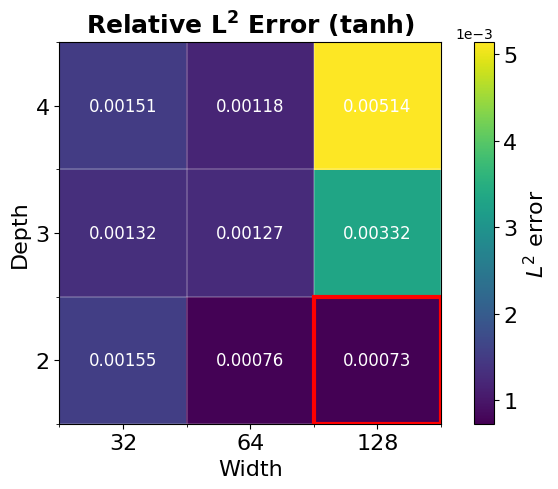

Saved: ../figs/heatmap_activation_tanh.pdf


In [ ]:
results = run_architecture_sweep(
    hidden_widths=[32, 64, 128],
    num_hidden_layers=[2, 3, 4],
    activation_fns={
        'tanh': jnn.tanh,
        'sine': jnp.sin,
        'GeLU': jnn.gelu,
        'SiLU': jnn.swish,
        'ReLU': jnn.relu,
    },
    T=0.5,
    steps=10000,
    N_int=1000,
    lr=5e-4,
    seeds=(4, 2, 16, 8, 29, 3, 21, 9, 0, 42),
    save_to_csv=False,
    use_pre_computed=True,
    data_dir="../data",
)

plot_all_heatmaps(results, save_dir="../figs", show=True)